In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-05-09 15:37:03 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.13.2
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.24.3
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8597
8 photutils  1.6.0
9 version_information 1.0.4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()
from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import rcParams

plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix', 
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5, 
    'xtick.top': True, 'ytick.right': True, 
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip

from photutils.background import Background2D

import sep
import ysfitsutilpy as yfu

import _tool_visualization as vis

FIGPATH = Path("figs")
DATAPATH = Path("../../Tutorial_Data")
fpath = DATAPATH/"SNUO_STX16803-kw4-4-4-20190602-135247-R-60.0_bdfw.fits"

In [3]:
box = 32
filt = 3

bkg_path = fpath.parent / (fpath.name[:-5] + '_bkg.png')
png_path = fpath.parent / (fpath.name[:-5] + '.png')
hdu = fits.open(fpath)[0]
data = hdu.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5)
thresh = med + 5 * std
mask = (data > thresh)  # mask = True when pixel has high signal (possibly a celestial object)

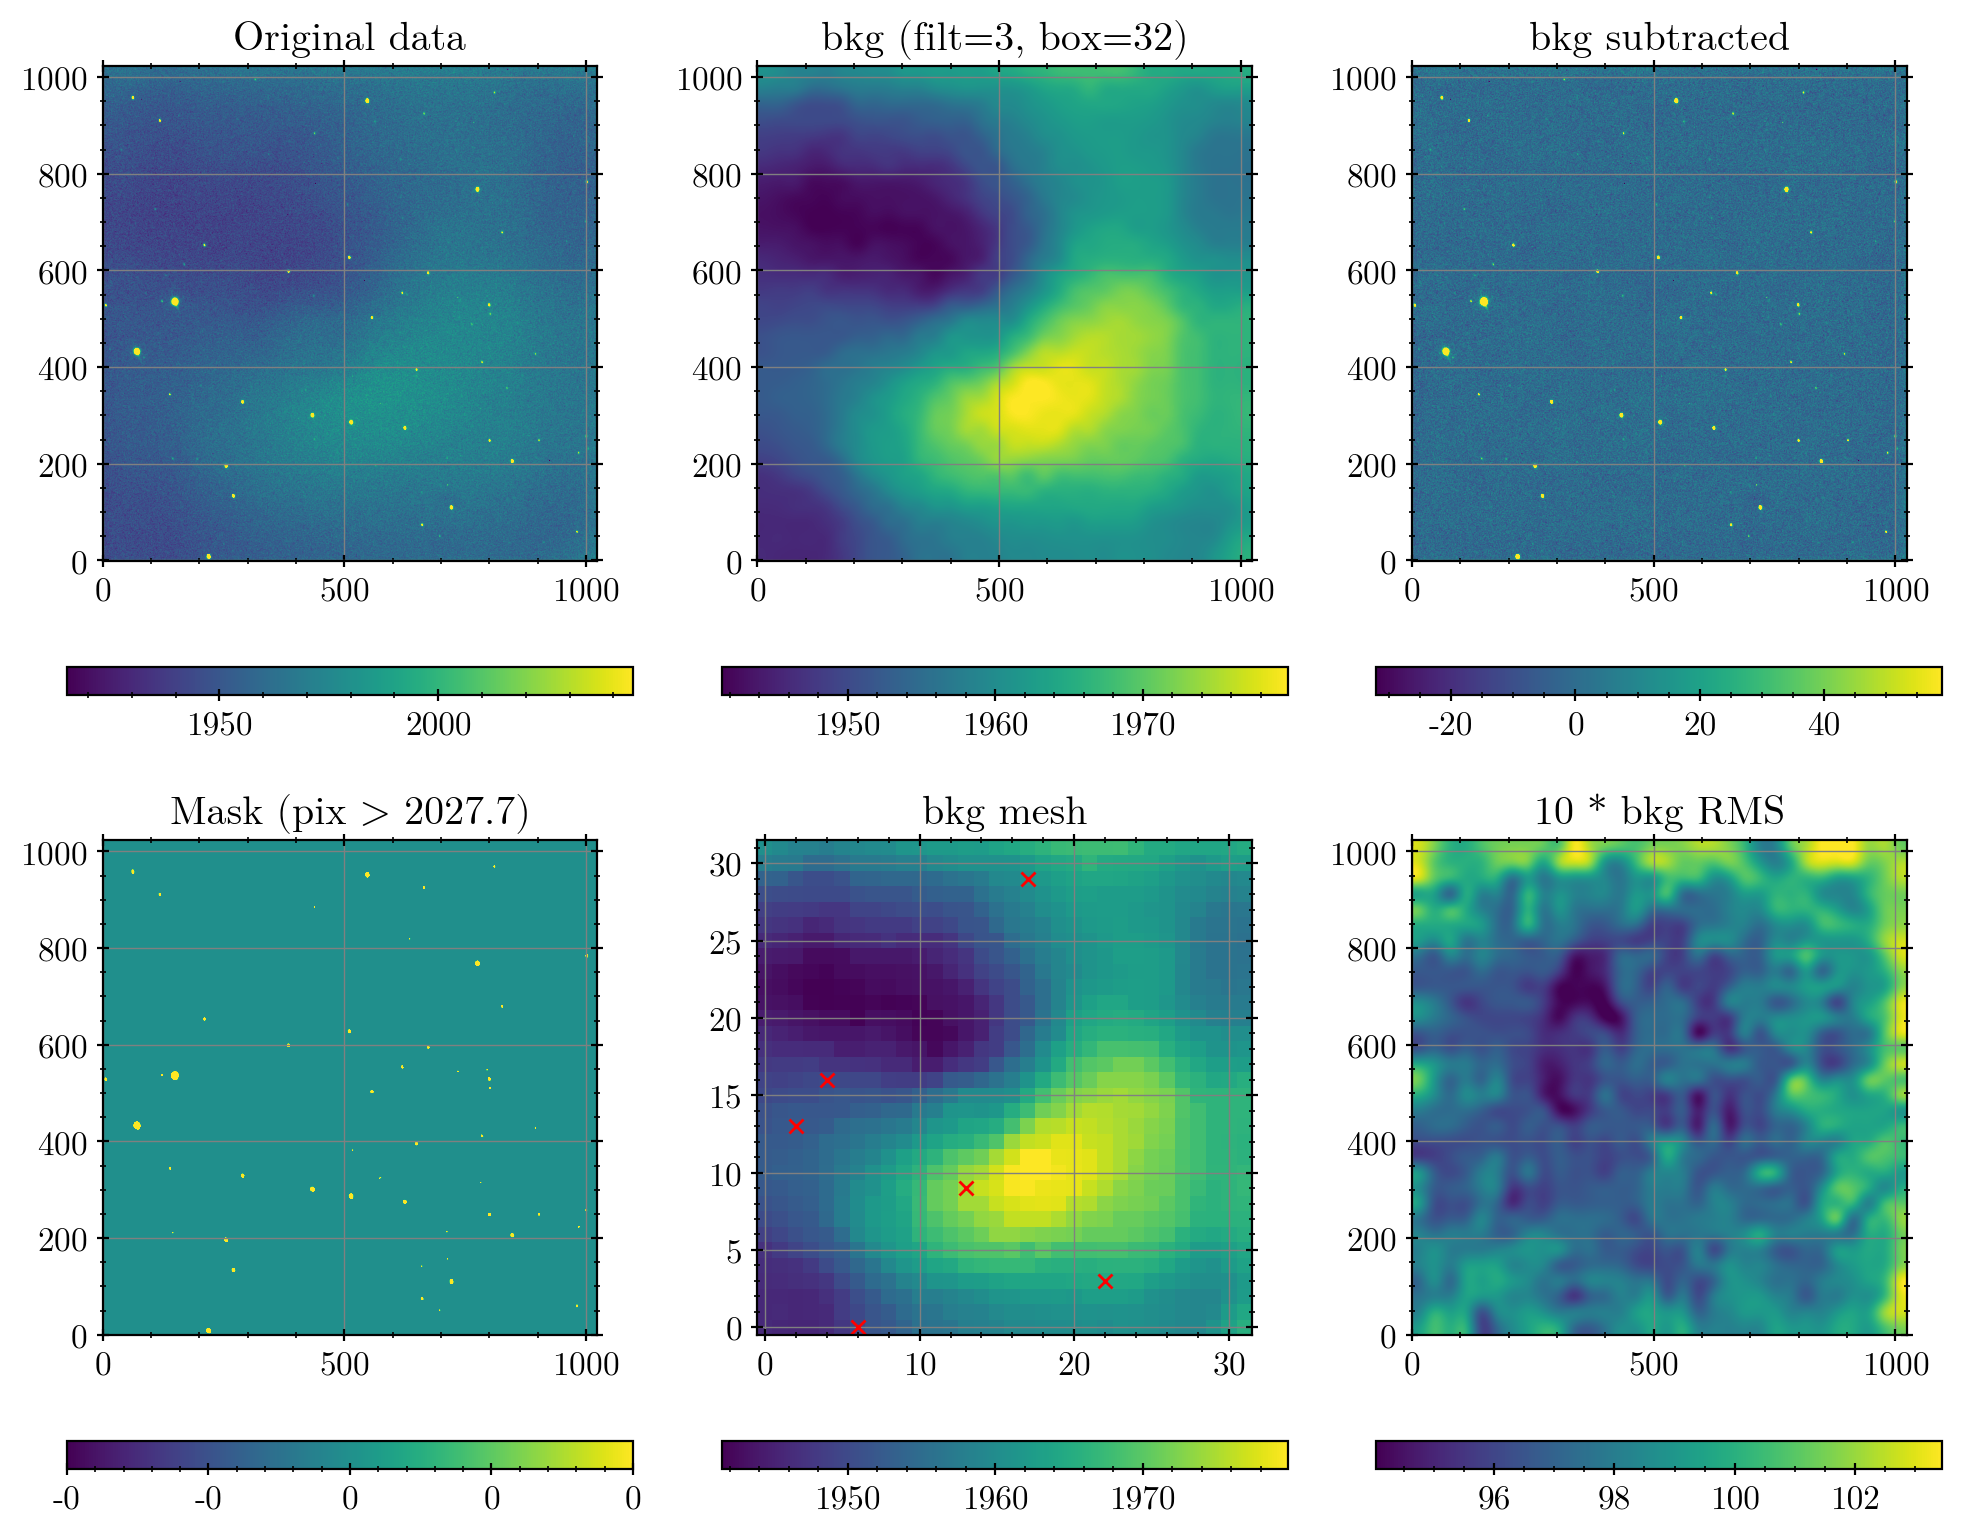

In [4]:
bkg_sex = Background2D(
    data,
    box_size=box,
    mask=mask,
    filter_size=filt,
    exclude_percentile=5,
    # sigma_clip=SigmaClip(sigma=3, maxiters=5, cenfunc='median', stdfunc='std')
)
bkgsub_sex = data - bkg_sex.background

fig, axs = plt.subplots(2, 3, figsize=(10, 8))

data2plot = [
    dict(ax=axs[0, 0], arr=data, title="Original data"),
    dict(ax=axs[0, 1], arr=bkg_sex.background, title=f"bkg (filt={filt:d}, box={box:d})"),
    dict(ax=axs[0, 2], arr=bkgsub_sex, title="bkg subtracted"),
    dict(ax=axs[1, 0], arr=mask, title=f"Mask (pix > {thresh:.1f})"),
    dict(ax=axs[1, 1], arr=bkg_sex.background_mesh, title="bkg mesh"),
    dict(ax=axs[1, 2], arr=10*bkg_sex.background_rms, title="10 * bkg RMS")
]

for dd in data2plot:
    im = vis.zimshow(dd['ax'], dd['arr'])
    vis.colorbaring(fig, dd['ax'], im)
    dd['ax'].set_title(dd['title'])

# bkg_sex.plot_meshes(ax=axs[0, 1])

try:
    axs[1, 1].plot(*np.where(np.isnan(bkg_sex.mesh_nmasked))[::-1], 'rx', ms=5)
except AttributeError:
    print("No mesh (pad) is masked ")

plt.tight_layout()
# plt.savefig(FIGPATH / "sex_bkg_01.png", bbox_inches='tight')

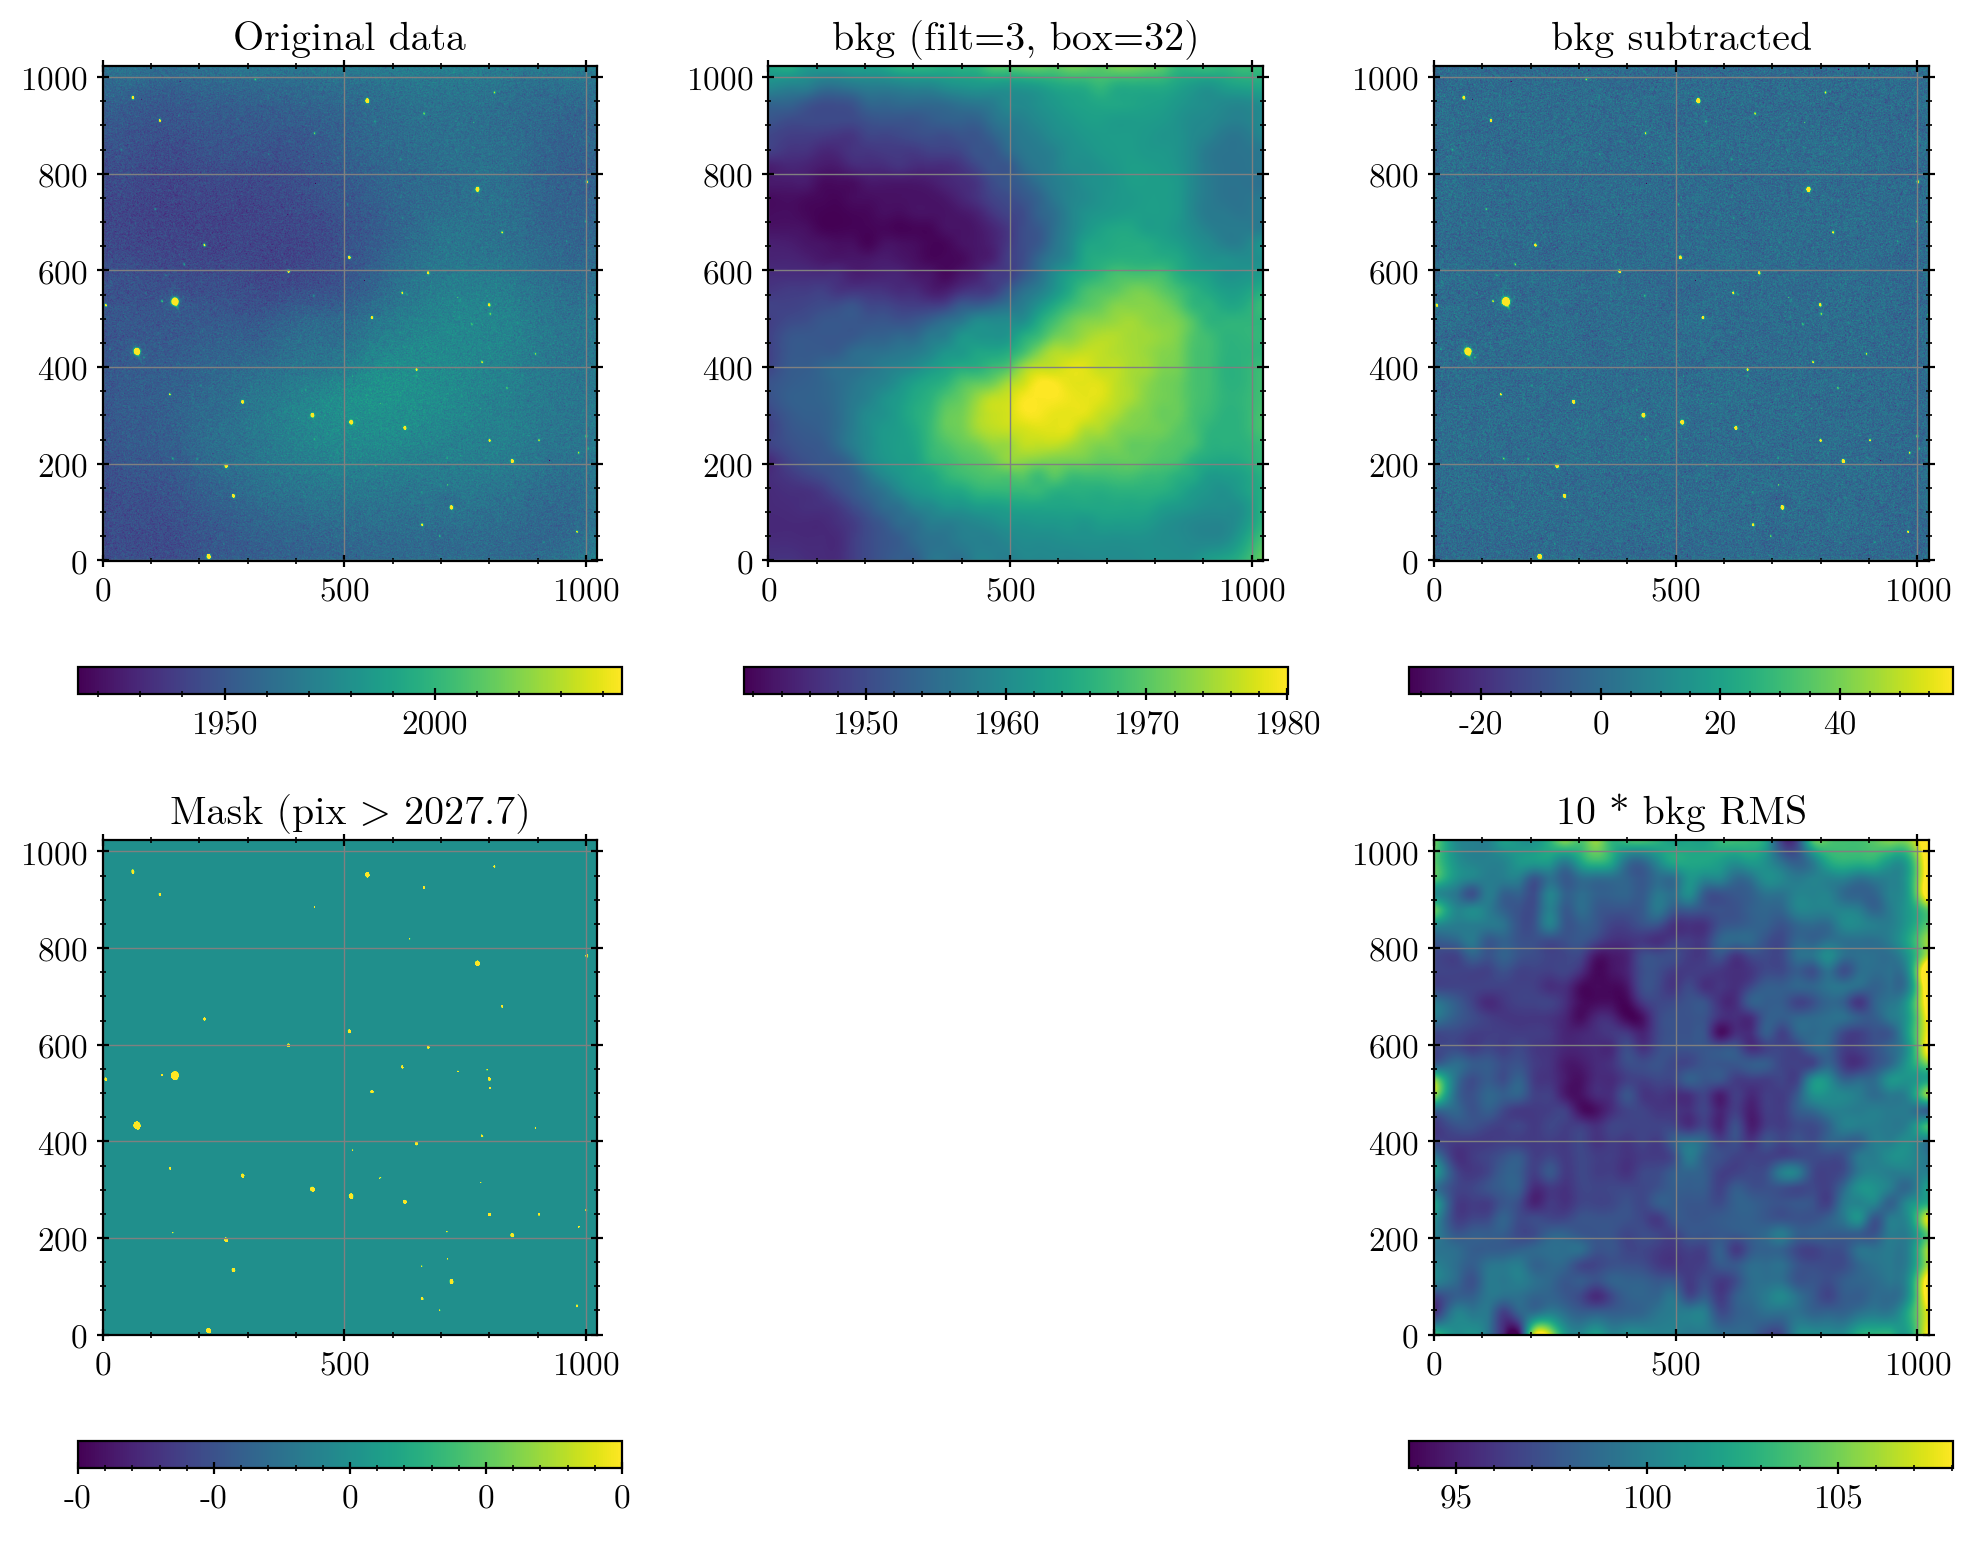

In [5]:
bkg_sep = sep.Background(
    data.byteswap().newbyteorder(),
    mask=mask, bw=box, bh=box, fw=filt, fh=filt
)

bkgsub_sep = data - bkg_sep.back()

fig, axs = plt.subplots(2, 3, figsize=(10, 8))
axs[1, 1].axis("off")

data2plot = [
    dict(ax=axs[0, 0], arr=data, title="Original data"),
    dict(ax=axs[0, 1], arr=bkg_sep.back(), title=f"bkg (filt={filt:d}, box={box:d})"),
    dict(ax=axs[0, 2], arr=bkgsub_sep, title="bkg subtracted"),
    dict(ax=axs[1, 0], arr=mask, title=f"Mask (pix > {thresh:.1f})"),
    dict(ax=axs[1, 2], arr=10*bkg_sep.rms(), title="10 * bkg RMS")
]

for dd in data2plot:
    im = vis.zimshow(dd['ax'], dd['arr'])
    vis.colorbaring(fig, dd['ax'], im)
    dd['ax'].set_title(dd['title'])

plt.tight_layout()
# plt.savefig(FIGPATH / "sex_bkg_01.png", bbox_inches='tight')

Statistics of the difference
           num: 1048576
           min: -6.857295142906423
           max: 3.0729636590508562
           avg: -0.09737848032452191
           med: 0.0026730014051281614
           std: 0.5489521792690334
        madstd: 0.07000631371216799
   percentiles: [1, 99]
           pct: [-2.93927157  0.69085835]
        slices: None
          zmin: -0.47009813126558825
          zmax: 0.4798942741889543


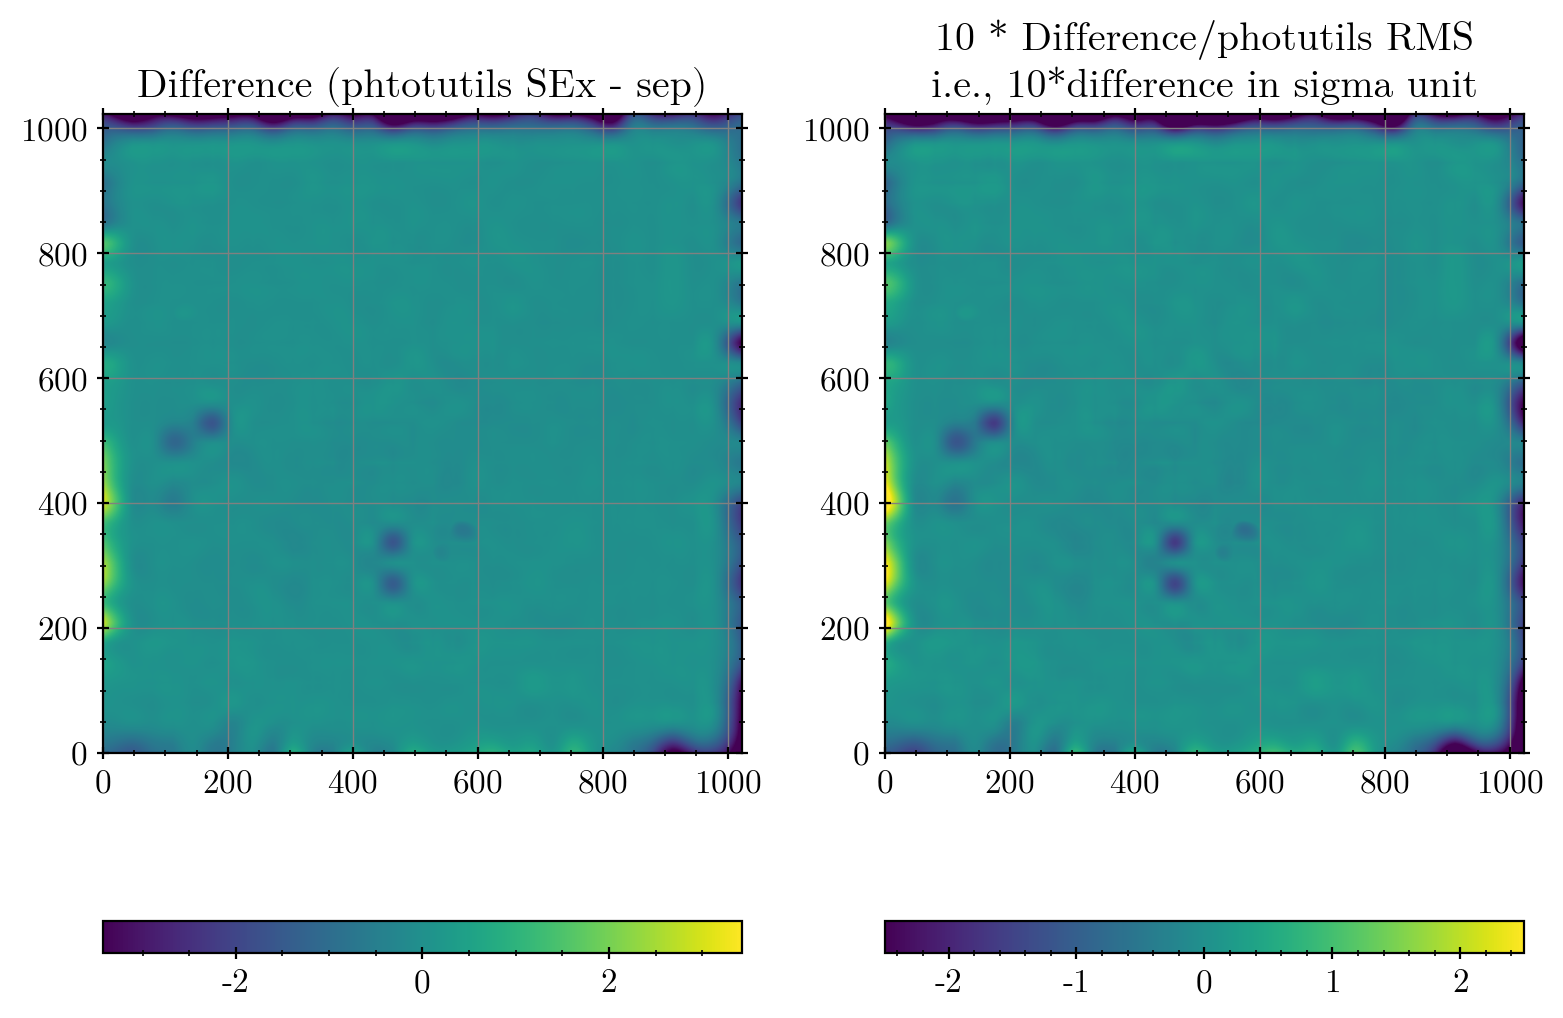

In [6]:
diff = bkg_sex.background - bkg_sep.back()
ss = yfu.give_stats(diff)
print("Statistics of the difference")
for k, v in ss.items():
    print(f"{k:>14s}: {v}")

fig, axs = plt.subplots(1, 2, figsize=(8, 6))

absmax = np.max(np.abs(diff))
im0 = axs[0].imshow(diff, origin='lower', vmin=-absmax/2, vmax=absmax/2)
vis.colorbaring(fig, axs[0], im0)

im1 = axs[1].imshow(10*diff/bkg_sex.background_rms, origin='lower', vmin=-2.5, vmax=2.5)
vis.colorbaring(fig, axs[1], im1)

axs[0].set(title="Difference (phtotutils SEx - sep)")
axs[1].set(title="10 * Difference/photutils RMS\ni.e., 10*difference in sigma unit")

plt.tight_layout()
plt.show()

# plt.savefig(figoutpath, dpi=300, bbox_inches = "tight")